In [1]:
# -*- coding: utf-8 -*- 

import numpy as np
import pandas as pd
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras as K
from tensorflow.keras import Sequential, layers, losses, optimizers, datasets
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from pathlib import Path
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# data generator class
class DataGenerator(Sequence):
    def __init__(self, ids, niis_dir, modulation_path, batch_size=16, shuffle=True):
        self.id_names = ids
        self.indexes = np.arange(len(self.id_names))
        self.niis_dir = Path(niis_dir)
        self.target = np.load(modulation_path, allow_pickle=True)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    # for printing the statistics of the function
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.id_names))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation__(self, id_name): # 1 부터 시작
        'Generates data containing batch_size samples'
        # Initialization
        subject_id, r0 = divmod(id_name, 720)
        run, t = divmod(r0, 240)
        nii_path = self.niis_dir / f'sub-{subject_id+1:02d}/run-{run+1}/{t}.pkl' # 이미지 1개 경로
        nii = np.load(nii_path, allow_pickle=True).flatten()
        target = self.target[subject_id, run, t]
        
        return nii, target

    def __len__(self):
        "Denotes the number of batches per epoch"
        # self.id_names: 존재하는 전체 데이터 개수
        # self.batch_size: 배치사이즈를 의미합니다.
        return int(np.floor(len(self.id_names) / self.batch_size))

    def __getitem__(self, index):  # index : batch no.
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_ids = [self.id_names[k] for k in indexes]

        niis = []
        targets = []
        
        for id_name in batch_ids:
            nii, target = self.__data_generation__(id_name)
            niis.append(nii)
            targets.append(target)

        niis = np.array(niis)
        targets = np.array(targets)

        return niis, targets  # return batch

In [3]:
# data generator class
class DataGenerator2(Sequence):
    def __init__(self, ids, niis_dir, modulation_path, batch_size=16, shuffle=True):
        self.id_names = ids
        self.indexes = np.arange(len(self.id_names))
        self.niis_dir = Path(niis_dir)
        self.target = np.load(modulation_path, allow_pickle=True)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    # for printing the statistics of the function
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.id_names))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation__(self, id_name): # 1 부터 시작
        'Generates data containing batch_size samples'
        # Initialization
        subject_id, r0 = divmod(id_name, 720)
        run, t = divmod(r0, 240)
        nii_path = self.niis_dir / f'sub-{subject_id+1:02d}/run-{run+1}/{t}.pkl' # 이미지 1개 경로
        nii = np.load(nii_path, allow_pickle=True).flatten()
        target = self.target[subject_id, run, t]
        
        return nii, target

    def __len__(self):
        "Denotes the number of batches per epoch"
        # self.id_names: 존재하는 전체 데이터 개수
        # self.batch_size: 배치사이즈를 의미합니다.
        return int(np.floor(len(self.id_names) / self.batch_size))

    def __getitem__(self, index):  # index : batch no.
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_ids = [self.id_names[k] for k in indexes]

        niis = []
        targets = []
        
        for id_name in batch_ids:
            nii, target = self.__data_generation__(id_name)
            niis.append(nii)
            targets.append(target)

        niis = np.array(niis)
        targets = np.array(targets)

        return niis, targets  # return batch

In [4]:
def do_balance(modulation):
    removed_candidates = []
    grouped = [0] * 11
    
    for i in range(modulation.shape[0]):
        for j in range(modulation.shape[1]):
            for k in range(modulation.shape[2]):
                if modulation[i, j, k] >= 1:
                    grouped[-1] += 1
                
                test = int(str(modulation[i, j, k][0])[2])
                
                if grouped[test] < 1250:
                    grouped[test] += 1
                else:
                    removed_candidates.append(((720 * i) + (240 * j) + k))
    return removed_candidates

In [5]:
niis_path = '/data2/project_modelbasedMVPA/prepprep'
modulation_path = './modulation.pkl'

ids = range(16 * 3 * 240)
modulation = np.load(modulation_path, allow_pickle=True)
removed_candidates = do_balance(modulation)

ids = list(set(ids) - set(removed_candidates))
print(len(ids))
train_ids, valid_ids = train_test_split(ids, test_size=0.2, random_state=42)

train_generator = DataGenerator(train_ids, niis_path, modulation_path)
valid_generator = DataGenerator(valid_ids, niis_path, modulation_path)

7608


In [8]:
batch_size = 256
epochs = 30

print("total training batches: ", len(train_generator))
print("total validaton batches: ", len(valid_generator))
train_steps = len(train_ids) // batch_size
valid_steps = len(valid_ids) // batch_size

optimizer_fn = optimizers.Adam(lr=0.003, decay=1e-5)
loss_fn = losses.MeanSquaredError()

filepath = 'ml_models/mlp_ep{epoch:02d}_vloss-{val_loss:.4f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
# callbacks = [checkpoint]
callbacks = []

total training batches:  380
total validaton batches:  95


In [9]:
mirrored_strategy = tf.distribute.MirroredStrategy() # for multi-gpus

with mirrored_strategy.scope():
    model = Sequential()
    model.add(Dense(1024, activation='relu', input_shape=(902629,)))
    model.add(BatchNormalization())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='relu'))
    model.compile(loss=loss_fn, optimizer=optimizer_fn)

# fit model
model.fit_generator(generator=train_generator, validation_data=valid_generator,
                    steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    workers=16, epochs=epochs, callbacks=callbacks)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.
23/23 [==============================] - 104s 5s/step - loss: 2.2513 - val_loss: 7.2325
Epoch 2/30
23/23 [==============================] - 96s 4s/step - loss: 0.2412 - val_loss: 0.3057
Epoch 3/30
23/23 [==============================] - 89s 4s/step - loss: 0.2721 - val_loss: 0.2474
Epoch 4/30
23/23 [==============================] - 90s 4s/step - loss: 0.2552 - val_loss: 0.2792
Epoch 5/30
23/23 [==============================] - 89s 4s/step - loss: 0.2410 - val_loss: 0.2541
Epoch 6/30
23/23 [==============================] - 88s 4s/step - loss: 0.2188 - val_loss: 0.2373
Epoch 7/30
23/23 [==============================] - 90s 4s/step - loss: 0.2057 - val_loss: 0.2109
Epoch 8/30
23/23 [==============================] - 8

In [24]:
model

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


In [ ]:
# model.save('mlp_model2')

In [6]:
weights_list = model.get_weights()

In [7]:
print(len(weights_list))
print(len(weights_list[0]))

26
902629


In [8]:
import pickle
with open('weight_first_layer2.pkl', 'wb') as f:
    pickle.dump(weights_list[0], f, pickle.HIGHEST_PROTOCOL)

In [9]:
target = weights_list[0]

In [10]:
target = target.reshape(91,109,91,1)
print(target.shape)

ValueError: cannot reshape array of size 924292096 into shape (91,109,91,1)

In [12]:
valid_generator = DataGenerator(valid_ids, niis_path, targets_path, shuffle = False,batch_size=240)

In [13]:
train_generator = DataGenerator(train_ids, niis_path, targets_path,shuffle = False,batch_size=240)

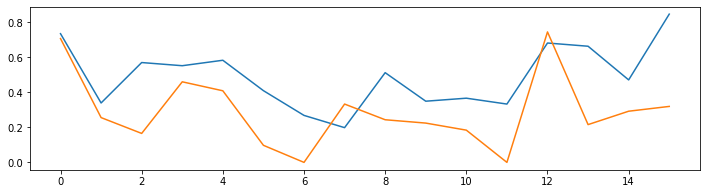

In [10]:
x = valid_generator[1][0]
y = valid_generator[1][1]

predicts = model.predict(x)
plt.figure(figsize=(12, 3))
plt.plot(y)
plt.plot(predicts)

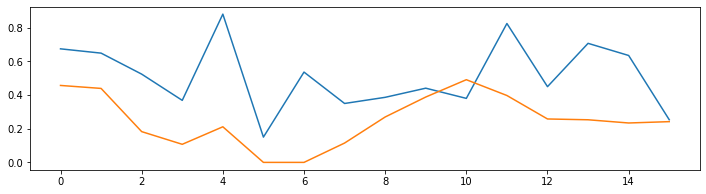

In [12]:
x = train_generator[1][0]
y = train_generator[1][1]

predicts = model.predict(x)
plt.figure(figsize=(12, 3))
plt.plot(y)
plt.plot(predicts)

(array([  48.,  336., 1008., 1264., 3360., 2784., 1504.,  704.,  368.,
         144.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

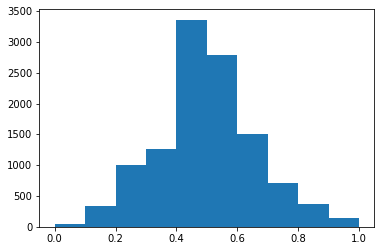

In [19]:
plt.hist(a.flatten())